In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# Dropout是一种常用的正则化技术，它可以在神经网络中减少过拟合，从而提高模型的泛化能力。
### Dropout会随机将神经网络的部分神经元输出置为0，这些神经元在训练中不参与计算梯度，而在测试时则恢复为正常状态。
在正向传播过程中，暂退的神经元不参与计算，其他神经元的输出需乘上一个缩放因子，即1/(1-p)，以保持激活值的期望不变

In [3]:
def dropout_layer(x,dropout):
    assert 0<=dropout<=1
    if dropout==1:#全删
        return torch.zeros_like(x)
    elif dropout==0:#全保留
        return x
    else:
        mask=(torch.rand(x.shape)>dropout).float()#大于dropout的才会被保留（dropout的概率为p，则不被dropout的概率为1-p，类似于伯努力随机试验）
        return mask*x/(1.0-dropout)#为了保持激活值的期望不变，我们需要对每个被保留的元素乘上一个缩放因子

In [4]:
x=torch.arange(16,dtype=torch.float32).reshape(2,8)
print(x)
print(dropout_layer(x,0))
print(dropout_layer(x,0.5))
print(dropout_layer(x,1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  0.,  8., 10.,  0.,  0.],
        [ 0., 18., 20.,  0.,  0., 26.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [5]:
num_input,num_output,hidden_layer1,hidden_layer2=784,10,256,256


In [12]:
# 标准暂退法包括在计算下一层之前将当前层中的一些节点置零。
dropout1,dropout2=0.2,0.5

# super(Net, self).__init__() 是 Python 中的一种方式，用于在子类中调用父类的方法。
# 在这里，Net 类继承自 nn.Module 类，而 nn.Module 类本身也有一些需要初始化的操作，例如需要初始化一个参数列表。
# 所以在 Net 类的 __init__ 方法中，需要调用 nn.Module 类的 __init__ 方法，以完成这些初始化工作。
# 因此，super(Net, self).__init__() 的作用就是调用父类（即 nn.Module 类）的 __init__ 方法。
class Net(nn.Module):
    def __init__(self,num_input,num_output,hidden_layer1,hidden_layer2,is_training=True):
        super(Net,self).__init__()
        self.num_input=num_input
        self.training=is_training
        self.lin1=nn.Linear(num_input,hidden_layer1)
        self.lin2=nn.Linear(hidden_layer1,hidden_layer2)
        self.lin3=nn.Linear(hidden_layer2,num_output)
        self.relu=nn.ReLU()
    def forward(self,x):
        # 它将输入的 X 数据进行线性变换，然后通过 self.relu 这个激活函数进行激活，得到第一个隐藏层的输出 H1
        h1 = self.relu(self.lin1(x.reshape((-1, self.num_input))))
        if self.training:
            h1=dropout_layer(h1,dropout1)
        h2=self.relu(self.lin2(h1))
        if self.training:
            h2=dropout_layer(h2,dropout2)
        out=self.lin3(h2)
        return out


In [13]:
net=Net(num_input,num_output,hidden_layer1,hidden_layer2)

# 简洁实现

In [18]:
net=nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),nn.Dropout(dropout1),nn.Linear(256,256),nn.ReLU(),nn.Dropout(dropout2),nn.Linear(256,10))
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

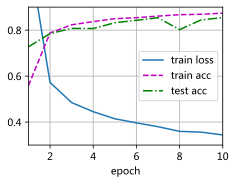

In [19]:
trainer=torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter=train_iter,test_iter=test_iter,loss=loss,num_epochs=num_epochs,updater=trainer)